# Imported accesories

In [107]:
import numpy as np
from vector_class import TripleVector
import matplotlib.pyplot as plt
import random
import sys
from numpy import random



# Parameters

In [108]:
A0 = 1e10 # Bq
Ab = 500 # Bq
h = 5 # m
D_t = 100 # the pause on each point od the grid in s
x_max = 4 # m
y_max = 4 # m
grid = [8, 8] # m
n_bins = 30

radiation = [A0, Ab, D_t]
detector = [h, x_max, y_max, grid]



# Code

## Flying over the surface

In [109]:
def I(A0, r, D_t):
    return (1 / (r + 1)**2) * A0 * D_t

def point_source(x_max, y_max):
    return [random.uniform(-x_max, x_max),random.uniform(-y_max, y_max)]

def flyOver(radiation, detector): # grid is a list which tells the number of tiles for x and y
    A0, Ab, D_t = radiation[0], radiation[1], radiation[2]
    h, x_max, y_max, grid = detector[0], detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y 
    xes = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    source = point_source(x_max, y_max)
    intensities = np.zeros((int(N_x), int(N_y)))
    intensities_list = []
    grid_x, grid_y = np.zeros((int(N_x), int(N_y))), np.zeros((int(N_x), int(N_y)))
    n, m = N_x - 1, 0
    y = -y_max + square_y/2
    i = 1
    max_intensity = {"number": [0], "postion": [[(0, 0), (0, 0)]]}
    for x in xes:
        while abs(y) <= y_max:
            drone = TripleVector(x, y, h)
            position = TripleVector(source[0], source[1], 0)
            r_vector = drone - position
            r = r_vector.magnitude()
            intensity = I(A0, r, D_t)
            if Ab*D_t > intensity:
                intensities[n, m] = 0
            else:
                intensities[n, m] = intensity - Ab*D_t
                intensities_list.append(intensity - Ab*D_t)
            grid_x[n, m], grid_y[n, m] = x, y
            if max_intensity["number"][0] < intensity:
                max_intensity["number"], max_intensity["position"] = [intensity], [[(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            elif max_intensity["number"][0] == intensity:
                max_intensity["position"] = [max_intensity["position"][0], [(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            y += (square_y)*i
            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square_y)*i
        m += 1

    return [intensities, source, intensities_list, grid_x, grid_y, max_intensity["position"]]

#  A0, Ab, D_t, h, x_max, y_max, square
measurement = flyOver(radiation, detector)

# print(measurement[0])



## Location from measurement

In [137]:
def circle_center(x, y, w=[]):
    A = np.array([x, y, np.ones(len(x))]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = np.diag(w)
        A = np.dot(W,A)
        b = np.dot(W,b)
    
    # Solve by method of least squares
    c = np.linalg.lstsq(A,b,rcond=None)[0]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = np.sqrt(c[2] + xc**2 + yc**2)
    return [xc, yc, r]

def find_source(measurement, n_bins):
    edge2, edge1 = np.max(measurement[0]), np.min(measurement[0])
    ran = np.linspace(edge1, edge2, n_bins)
    histogram = np.histogram(measurement[2], ran) # here the list of intensities becomes useful
    if max(histogram[0]) <= 2:
        sys.exit("Error to many bins - all of them contain less than three points. Reduce the number n_bins!")
    candidates = np.zeros((1, 2))
    borders = measurement[5]
    for fit_points in histogram[0]:
        if fit_points > 2:
            i = list(histogram[0]).index(fit_points)
            Range = histogram[1][i:(i+2)]
            n, m = measurement[0].shape
            X, Y = [], []
            for i in range(n):
                for j in range(m):
                    if (Range[0] <= measurement[0][i, j] and measurement[0][i, j] <= Range[1]):
                        X.append(measurement[3][i, j])
                        Y.append(measurement[4][i, j])
            points = [np.array(X), np.array(Y)]
            circle_values = circle_center(points[0], points[1])
            X_c, Y_c = circle_values[0], circle_values[1]
            for border in borders: # eliminate the circle centres that are out of the tile "hotspots"
                if (border[0][0] <= X_c and X_c <= border[0][1]) and (border[1][0] <= Y_c and Y_c <= border[1][1]):
                    candidates = np.vstack((candidates, np.array([X_c, Y_c])))
    return [candidates[1:, :], candidates[1:, :].mean(axis=0)]

points = find_source(measurement, 40)

# print(elimination(np.array([[ 0,  1],
#        [-0.5, 1.0],
#        [10, 11],
#        [15, 16]]), [[(-2.0, 2.0), (-3.0, 3.0)]]))


## Combine the measurement and location of the source

In [111]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

def combination(radiation, detector, n_bins):
    measurement = flyOver(radiation, detector)
    points = find_source(measurement, n_bins)
    #dr = dist_points(TripleVector(measurement[1][0], measurement[1][1], 0), TripleVector(circle_values[0], circle_values[1], 0))
    hotspot_tile = measurement[5]
    return [measurement, x_max, y_max, points, hotspot_tile]#, dr]



## Visualization

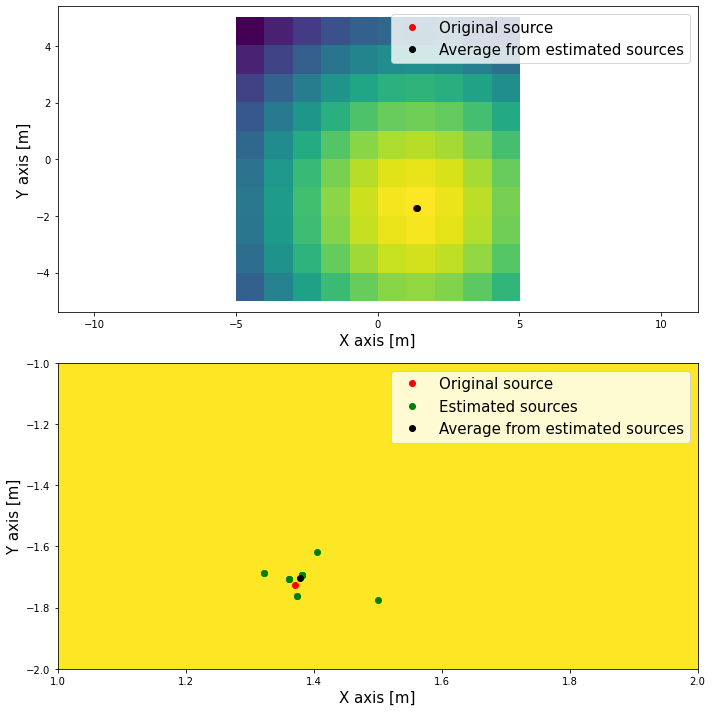

In [136]:
# COMMENT: Purple tiles are the ones where the signal is so weak that you cannot distiguish it from the background radiation

def visualize(measurement, x_max, y_max, points, hotspot):

    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 10))
    
    ax1.imshow(measurement[0], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement[1][0], measurement[1][1]
    ax1.plot(X, Y, "o", color = 'r', label = "Original source")
    ax1.plot(points[1][0], points[1][1], "o", color = 'k', label = "Average from estimated sources")
    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax1.legend(fontsize = 15)
    #plt.grid()

    ax2.imshow(measurement[0], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement[1][0], measurement[1][1]
    ax2.plot(X, Y, "o", color = 'r', label = "Original source")
    ax2.plot(points[0][:, 0], points[0][:, 1], "o", color = 'g', label = "Estimated sources")
    ax2.plot(points[1][0], points[1][1], "o", color = 'k', label = "Average from estimated sources")
    ax2.set_xlim(hotspot[0][0][0], hotspot[0][0][1])
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(hotspot[0][1][0], hotspot[0][1][1])
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)
    #plt.grid()
    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]


data = combination(radiation, detector, n_bins)

visualize(data[0], data[1], data[2], data[3], data[4])

# print(data[0][1])
# print(data[4])



## Error calculation

<ipython-input-110-abb89b7faecb>:57: RuntimeWarning: Mean of empty slice.
  return [candidates[1:, :], candidates[1:, :].mean(axis=0)]
C:\Users\urhtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


ValueError: x must have 2 or fewer dimensions

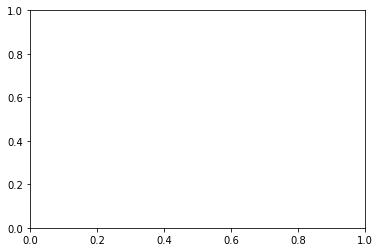

In [113]:
def gauss_r(radiation, detector, n_bins, n_sim):
    R = []
    for i in range(n_sim):
        dr = combination(radiation, detector, n_bins)[-1]
        R.append(dr)
    plt.hist(np.array(R), 100)
    plt.xlabel("r error [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("number of values", fontsize = 15)
    plt.yticks(fontsize = 15)

    #plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    #plt.savefig("")
    plt.show()

    d_R = np.std(R)

    return d_R

print(gauss_r(radiation, detector, n_bins, 1000))

# Describtion of the code

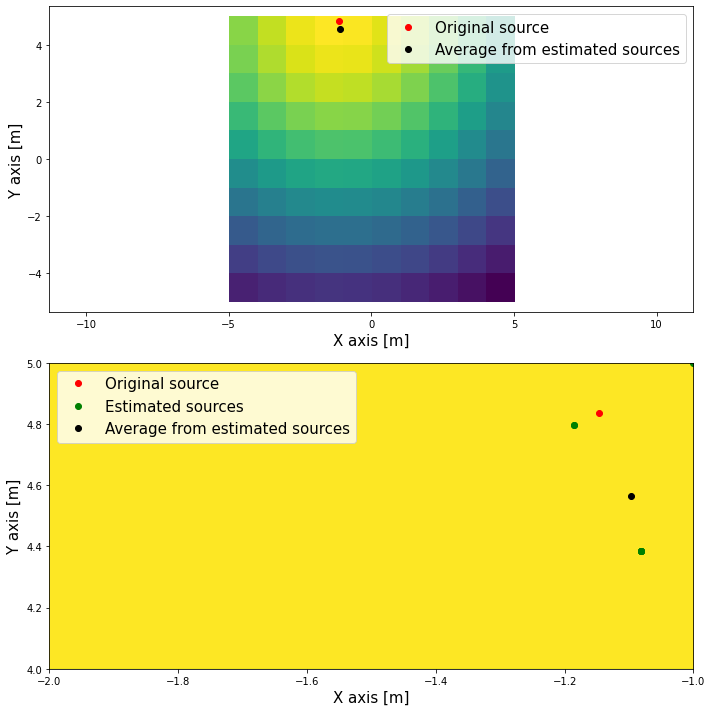

In [139]:
# PARAMETERS
A0 = 1e6 # activity of the source in Bq
Ab = 500 # background activity in Bq
h = 10 # hight at which the detector flies over in m
x_max = 5 # Size of the area of flyover in x direction in m
y_max = 5 # Size of the area of flyover in y direction in m
grid = [10, 10] # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the
                # number of radioactive decays. The first number is the number of these areas in x direction and the second is the number in y
                # direction
D_t = 100 # the pause on each point od the grid in s
n_bins = 20 # number of bins in the histogram made by find_source()

# DESCRIPTION OF THE CODE
# 1) flyOver() generates a single point source randomly somwhere on the grid specified by x_max and y_max. The detector then "flys over" at the
# hieght h starting in the bottom left tile and moving upward. When it reaches the upper left tile it moves right for one tile and goes down.
# This continues for the entire grid. At each point the detector stops for D_t and measures the intensity at that tile. This is estimated using
# the inverse square law, defined with the function I(). flyover() returns a list in which the first element is a n x m array, where n and m
# are the respective values in grid. Each entry in the array contains the intensity which coresponds to the measurement in the tile which has
# the position [n, m]. The second entry in the list is the position of the randomly generated point source. The third entry is a list of
# intensities, which will be useful in further code. The last two entries each contain an array of the same dimentions as the one in the 
# first entry of the list. The first one contains the x coordinates of the cenetr of tiles and the second one contains the same data just for 
# the y coodidinates.

# 2) find_Source() uses the data made by flyOver() to estimate the position of the point source. Beside that it takes one more parameter, n_bins. 
# this is the number of bins that will be used in a histogram made with the list of intensities measured with the detector fly-by. Using the 
# histogram we can group the intesities which are closely together according to the values. For all of the intensities that fall in the same
# bin we gather the point position of the detector. These points must lie on the same circle. We use the the numpay least square method to find 
# the center of such a circle. This proces is repeated for all of the bins that contain at least three intensities. The possible centers of 
# circles are then examined further. The ones which are located outside of the tile which has the largest intesity value ("hotspot" tile) are 
# disqualified. From the others we then calculate the average position and this is the end result of the function. The function returna an n x 2 
# array which contains the points which are averaged and an array which returns the calculated avarage point.
 
# Combinig the parameters into a list so that the data is more compacted
radiation = [A0, Ab, D_t]
detector = [h, x_max, y_max, grid]

data = combination(radiation, detector, n_bins)

visualize(data[0], data[1], data[2], data[3], data[4])